In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
%%time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.mixed_precision import experimental as mixed_precision

import efficientnet.tfkeras as efn

from sklearn.metrics import (f1_score, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix)

from kaggle_datasets import KaggleDatasets

import os
import re
import gc
import math
gc.enable()
import warnings; warnings.simplefilter("ignore")

CPU times: user 2.46 s, sys: 688 ms, total: 3.14 s
Wall time: 7.14 s


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(); print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
USE_FLOAT16 = True
XLA_ACCELERATE = False
if USE_FLOAT16:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Mixed precision enabled


In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [800, 800]
EPOCHS = 20
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [6]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
        
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [1024,1024, 3]) 
    image = tf.image.resize(image, [800,800])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

In [8]:
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')

In [9]:
def get_training_dataset(TRAINING_FILENAMES=TRAINING_FILENAMES, do_aug=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    if len(TRAINING_FILENAMES)>5: 
        dataset = dataset.repeat() 
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [10]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

print("Training data shapes:")
for image, label in get_training_dataset().take(1):
    print(image.numpy().shape, label.numpy().shape)

print("Test data shapes:")
for image, idnum in get_test_dataset().take(1):
    print(image.numpy().shape, idnum.numpy().shape)

Dataset: 33126 training images, 10982 unlabeled test images
Training data shapes:
(256, 800, 800, 3) (256,)
Test data shapes:
(256, 800, 800, 3) (256,)


In [11]:
def binary_focal_loss(gamma=2., alpha=.25):
    def binary_focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = K.epsilon()
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return binary_focal_loss_fixed

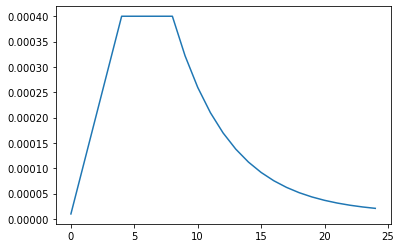

In [12]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lrs = [lrfn(i) for i in range(25)]
plt.plot(list(range(25)),lrs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [13]:
gc.collect()
VER = 'B4'
with strategy.scope():
    enet = efn.EfficientNetB4(
        input_shape=(800, 800, 3),
        weights='noisy-student',
        include_top=False
    )
    enet.trainable = True 

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid',dtype='float32')
    ]) 
    
    sv = tf.keras.callbacks.ModelCheckpoint(
        'efn-%s.h5'%(VER), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3,
                                      restore_best_weights=True, mode='auto')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss = [binary_focal_loss(gamma=2., alpha=.25)],
        metrics=["accuracy",tf.keras.metrics.AUC()]
    )
model.summary()

71680000/71678424 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 25, 25, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1793      
Total params: 17,675,609
Trainable params: 17,550,409
Non-trainable params: 125,200
_________________________________________________________________


In [14]:
import random
val_dataset = random.sample(TRAINING_FILENAMES,4)

history = model.fit(
    get_training_dataset(do_aug=True), 
    steps_per_epoch= NUM_TRAINING_IMAGES // BATCH_SIZE,
    epochs= EPOCHS,
    callbacks = [lr_callback, sv, es],
    shuffle = True,
    verbose = 1,
    validation_data = get_training_dataset(val_dataset, do_aug=False)
)

Train for 129 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
128/129 [============================>.] - ETA: 4s - loss: 1.1884 - accuracy: 0.9211 - auc: 0.5460
Epoch 00001: val_loss improved from inf to 1.09764, saving model to efn-B4.h5
129/129 [==============================] - 625s 5s/step - loss: 1.1813 - accuracy: 0.9216 - auc: 0.5458 - val_loss: 1.0976 - val_accuracy: 0.9825 - val_auc: 0.5465

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001075.
Epoch 2/20
128/129 [============================>.] - ETA: 1s - loss: 0.2414 - accuracy: 0.9825 - auc: 0.7852
Epoch 00002: val_loss improved from 1.09764 to 0.26581, saving model to efn-B4.h5
129/129 [==============================] - 264s 2s/step - loss: 0.2399 - accuracy: 0.9826 - auc: 0.7857 - val_loss: 0.2658 - val_accuracy: 0.9825 - val_auc: 0.6959

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000205.
Epoch 3/20
128/129 [============================>.] - ETA:

In [15]:
model.load_weights('efn-%s.h5'%(VER))
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds).flatten()
print(probabilities)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') 
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, probabilities**2]), fmt=['%s', '%f'], delimiter=',', header='image_name,target', comments='')
!head submission.csv

Computing predictions...
[0.02995113 0.00700551 0.00956714 ... 0.08052039 0.00971207 0.00414497]
Generating submission.csv file...
image_name,target
ISIC_6381819,0.000897
ISIC_5583376,0.000049
ISIC_6408546,0.000092
ISIC_6932354,0.000085
ISIC_8191278,0.000498
ISIC_9978346,0.000001
ISIC_1469194,0.000155
ISIC_0394763,0.000039
ISIC_9846836,0.000102
